In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
import pandas as pd

In [3]:
class arguments:
    T = 1000
    
    mu = 1.0
    L = 3.0
    kappa = L/mu

    d = 3
    N = 20
    
    x0 = 100.0 #1.0

    A = torch.diag(torch.tensor((np.arange(1,d+1)).astype(np.float32)))
    print(f"A:{A}")

    c = 1.0
    sigma = .5 # 1e-5
    
    beta = 1
    
    reps = 100
    plot_every = 50
    print_every = reps/10

arg = arguments()

A:tensor([[1., 0., 0.],
        [0., 2., 0.],
        [0., 0., 3.]])


In [41]:
def beta_opt(R, arg):
    return max(9*(arg.kappa), 12*(arg.c*arg.kappa)**2*max(np.log(3), np.log(1.0 + arg.T/(4*arg.kappa*(R**2)))) +3*arg.kappa*(1.0+(arg.c**2)/arg.N))

print(int(beta_opt(arg.N, arg)))

128


In [42]:
def F(x, arg, stochastic = True, normal=True):
    if stochastic:
        if normal:
            z1 = arg.c*torch.randn_like(x)
            z2 = arg.sigma*torch.randn_like(x)
        else:
            z1 = torch.tensor(np.random.laplace(scale=arg.c, size=x.shape).astype(np.float32))
            z2 = torch.tensor(np.random.laplace(scale=arg.sigma, size=x.shape).astype(np.float32))
    else:
        z1 = 0
        z2 = 0

    output = 0.5*x*torch.matmul(arg.A,x)*(1 + z1) + z2*x
    return torch.sum(output, 0)

In [43]:
with torch.no_grad():
    loss_0 = F(arg.x0*torch.ones((arg.d,1)), arg, stochastic=False).item()
    print(loss_0)

30000.0


## One worker test

In [44]:
x = torch.tensor(arg.x0*np.ones((arg.d,1), dtype=np.float32), requires_grad = True)

optimizer = optim.SGD([x], lr=1.0)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: 3/(arg.mu*(t+arg.beta)), last_epoch=-1)

avg_loss = 0.0
avg_losses = [loss_0]
actual_losses = [loss_0]

for t in range(arg.T):
    optimizer.zero_grad()
    loss = F(x, arg)
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    with torch.no_grad():
        actual_loss = F(x, arg, stochastic=False)
    actual_losses.append(actual_loss)
    avg_loss += actual_loss
    
    if (t+1)%arg.plot_every == 0:
        avg_loss /= arg.plot_every
        avg_losses.append(avg_loss)
        avg_loss = 0.0
        
print('loss: %.5f' %  (actual_loss))
print(x)

loss: 0.00008
tensor([[-0.0086],
        [ 0.0060],
        [ 0.0021]], requires_grad=True)


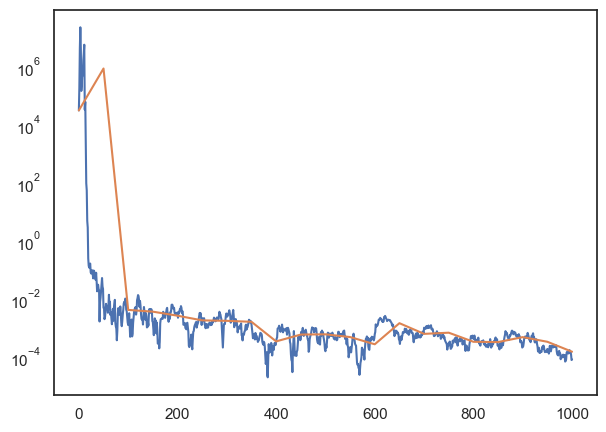

In [45]:
# plt.figure(figsize=(4,3))
plt.plot(actual_losses)
plt.plot(np.arange(len(avg_losses))*arg.plot_every, avg_losses, '-')

plt.yscale('log')
# plt.ylim([0,1e-12])
plt.show()

In [46]:
plot_labels = {0:r'Synchronous SGD', 1:r'[Sti19]', 2:'[HKMC19]', 3:'$H_i = a(i+1)$ [This Paper]', 4: r'$H = T/N$', 5:r'$H=T$ (OSA)'}

def get_comms(method, arg, N=None, T=None):
    if not N:
        N = arg.N
        T = arg.T
    
    if method == 0:
        comms = np.arange(T+1)
        print('synchronous')
        
    elif method == 1:
        H = int(np.sqrt(T/N))
        print(f"H={H}")
        
        comms = [H*t for t in range(T//H + 1)]
        plot_labels[method] = r'$H=%d$ [Sti19]' %H

    elif method == 2:
        H = int(((T**2)/N)**(1/3))
        print(f"H={H}")
        comms = [H*t for t in range(T//H + 1)]
        
        plot_labels[method] = r'$H=%d$ [HKMC19]' %H
        
    elif method == 3: # This Paper
        R = N #int(N*arg.kappa)
#         a = int(np.ceil(2*T/(k**2)))
        a = 2*T/(R*(R+1))
        print(f"R:{R}, a:{a}")
        plot_labels[method] = r'$H_i~%d(i+1)$ (This Paper)' % int(a)
        
        comms = [int(a*r*(r+1)/2) for r in range(R+1)]
#         comms = [0]
#         last_float = 0.0
#         for r in range(1,R+1):
#             last_float += r*a
#             print(last_float)
#             comms.append(int(np.ceil(last_float)))
#             assert comms[-1] > comms[-2]
#         comms = []
#         for i in range(k):
#             comm = a*i*(i+1)/2
#             if comm <= T:
#                 comms.append(comm)

    elif method == 4:
        R = N #int(N*arg.kappa)
        H = arg.T/R
        print(f"H={H}")
        comms = [int(np.ceil(H*r)) for r in range(R+1) if H*r <= T]
        plot_labels[method] = r'$H=%d~(T/N)$' %H

    elif method == 5:
        comms = [0,T]
        print(r'H=T (OSA)')

    if comms[-1] != T:
        comms.append(T)
        
    comms = np.array(comms, dtype = int)
#     print(comms)
    return comms

In [47]:
def train_dist(comms, arg):
    comm_error_sum = np.zeros(len(comms))
    iter_error_sum = np.zeros(np.ceil(arg.T/arg.plot_every + 1).astype(int))
    iter_error2_sum = np.zeros(np.ceil(arg.T/arg.plot_every + 1).astype(int))
    
    
    for rep in range(arg.reps):

        X = torch.tensor(arg.x0*np.ones((arg.d,arg.N), dtype=np.float32),requires_grad = True)
        optimizer = optim.SGD([X], lr=1.0)
        scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: 3/(arg.mu*(t+arg.beta)), last_epoch=-1)
        
        comm_error = [loss_0]
        iter_error = [loss_0]
        for t in range(arg.T):
            optimizer.zero_grad()
            loss = F(X, arg).sum()

            loss.backward()
            optimizer.step()
            scheduler.step()
            
            if (t+1) in comms: # calculating the average of workers' parameters
                x_avg = torch.mean(X.data, dim = 1).unsqueeze(1)
                X.data = torch.ones_like(X)*x_avg
                
                with torch.no_grad():
                    actual_loss = F(x_avg, arg, stochastic=False).item()
                
                comm_error.append(actual_loss)


            if (t+1) % arg.plot_every == 0  or (t+1)==arg.T:
                x_avg = torch.mean(X.data, dim = 1).unsqueeze(1)
                with torch.no_grad():
                    actual_loss = F(x_avg, arg, stochastic=False).item()
                iter_error.append(actual_loss)


        comm_error_sum += np.array(comm_error)
        iter_error_sum += np.array(iter_error)
        iter_error2_sum += np.array(iter_error)**2
        
        if (rep+1) % arg.print_every == 0:
#             print('Simulation: %d/%d'%(rep+1, arg.reps))
                print('.', end='')
    print('')
    
    comm_error_avg = comm_error_sum/arg.reps
    iter_error_avg = iter_error_sum/arg.reps
    iter_error2_avg = iter_error2_sum/arg.reps
    
    return {'comm_error_avg': comm_error_avg, 'iter_error_avg': iter_error_avg, 'iter_error2_avg': iter_error2_avg}

method 0
synchronous
# of comms: 1000
..........
method 1
H=7
# of comms: 143
..........
method 2
H=36
# of comms: 28
..........
method 3
R:20, a:4.761904761904762
# of comms: 20
..........
method 4
H=50.0
# of comms: 20
..........
method 5
H=T (OSA)
# of comms: 1
..........


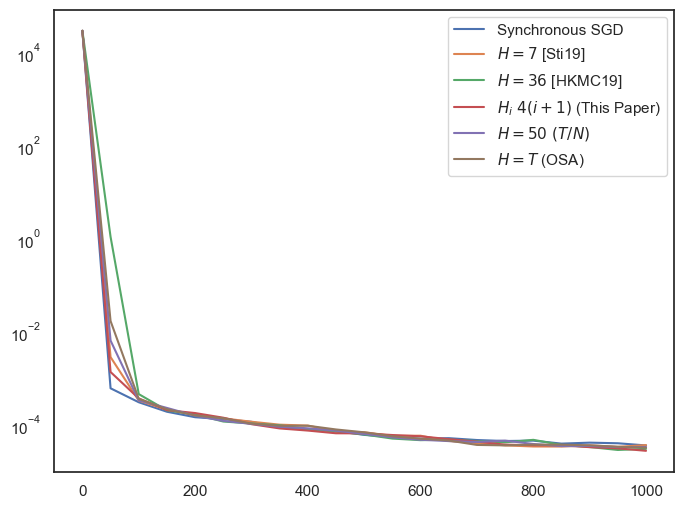

In [48]:
iter_avg_dict = {}
iter_std_dict = {}
comm_dict = {}
plt.figure(figsize= (8,6))

methods = [0,1,2,3,4,5]
for method in methods:
    print('method %d'% method)
    comms = get_comms(method, arg)
    print('# of comms: %d' % (len(comms)-1))
    
    
    result = train_dist(comms, arg)
    
    comm_dict[method] = result['comm_error_avg']
    iter_avg_dict[method] = result['iter_error_avg']
    iter_std_dict[method] = np.sqrt(result['iter_error2_avg'] - result['iter_error_avg']**2)/np.sqrt(arg.reps)
    
    
#     plt.fill_between(plot_every*np.arange(len(iter_error_avg)), iter_error_avg - iter_std, iter_error_avg + iter_std, alpha = 0.3)
    plt.plot(arg.plot_every*np.arange(len(result['iter_error_avg'])), result['iter_error_avg'], '-', label = plot_labels[method])
#     print('------')
    
plt.yscale('log')
plt.legend()
plt.show()

# Save results to a file
file_name = 'results/quadratic_gaussian.pkl'
with open( file_name, 'wb') as f:
    pickle.dump({'iter_avg_dict': iter_avg_dict, 'iter_std_dict': iter_std_dict,
                 'comm_dict': comm_dict, 'arg': arg, 'plot_labels': plot_labels}, f)
    f.close()
print('file saved: ' + file_name)

In [4]:
# loading data
file_name = 'results/quadratic_gaussian.pkl'
data = pickle.load(open(file_name, 'rb'))
print(data.keys())
try:
    iter_avg_dict = data['iter_avg_dict']
    comm_dict = data['comm_dict']
    iter_std_dict = data['iter_std_dict']    
    
    arg = data['arg']
    
    methods = iter_avg_dict.keys()
    
    plot_labels = data['plot_labels']
except:
    pass

del data

dict_keys(['iter_avg_dict', 'iter_std_dict', 'comm_dict', 'arg', 'plot_labels'])


## Plotting the results

In [5]:
sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(7,5)}, 
    style="white" # nicer layout
)

## iteration error

In [16]:
# Combining the outputs in one dataframe for Seaborn
errors = []
txerrors = []

# errors_std = []
# txerrors_std = []

iterations = []
methods_list = []
for m in methods:
    errors = np.append(errors, iter_avg_dict[m])
    txerrors = np.append(txerrors, iter_avg_dict[m]*(arg.plot_every*np.arange(len(iter_avg_dict[m]))))

#     errors_std = np.append(errors_std, iter_std_dict[m])
#     txerrors_std = np.append(txerrors_std, iter_std_dict[m]*(arg.plot_every*np.arange(len(iter_std_dict[m]))))
    
    iterations = np.append(iterations, arg.plot_every*np.arange(len(iter_avg_dict[m])))
    methods_list += [m]*len(iter_avg_dict[m])


iter_df = pd.DataFrame({'iter': iterations, 'error': errors, 'txerror': txerrors, 'method': methods_list}) #, 'std': errors_std,  'txstd': txerrors_std})
iter_df.head()

,iter,error,txerror,method
0,0.0,3.000000e+00,0.000000e+00,0
1,50.0,1.522681e-10,7.613405e-09,0
2,100.0,2.323414e-12,2.323414e-10,0
3,150.0,2.748891e-13,4.123336e-11,0
4,200.0,9.540712e-14,1.908142e-11,0


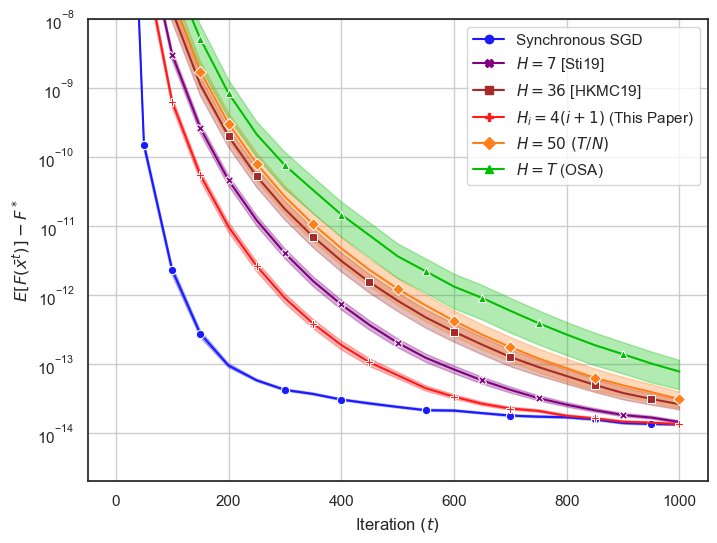

In [37]:
plot_colors = {0:(0.1, 0.1, 1),
               1:'purple',
               2:'brown',
               3:(1, 0.1, 0.1),
               4:(1,.5,0.1),
               5:(0,.75,0)}

plt.figure(figsize=(8,6))

ax = sns.lineplot(x = 'iter', y= 'error', data = iter_df, #.loc[iter_df['method'].isin([plot_labels[i] for i in [0,3]])],
                  hue = 'method',
#                   palette = 'bright',
                  palette = plot_colors,
                  style = 'method',  markers = True, dashes = False, markevery=.1)

plt.gca().set_prop_cycle(None)
for m in methods:
    iter_std = iter_std_dict[m]
    plt.fill_between(
        arg.plot_every*np.arange(len(iter_std)),
        (iter_avg_dict[m] - iter_std),
        (iter_avg_dict[m] + iter_std),
        alpha=0.3,
        color = plot_colors[m],
    )

plt.yscale('log')
# plt.xscale('log')
plt.grid()
plt.xlabel(r'Iteration $(t)$')
plt.ylabel(r'$E[F(\bar x^t)] - F^*$')

# plt.xlim([0,1000])
plt.ylim([2e-15, 1e-8])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=[plot_labels[int(m)] for m in labels[1:]])

# plt.savefig('figures/iteration_skewed.png', dpi=240, transparent=False, bbox_inches='tight')
plt.show()

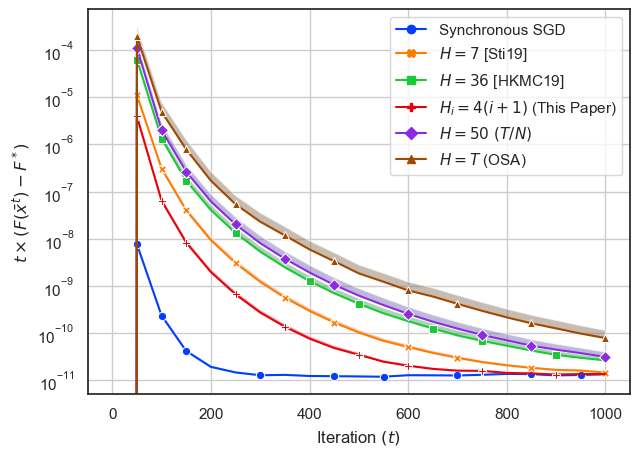

In [28]:
ax = sns.lineplot(x = 'iter', y= 'txerror', data = iter_df, #.loc[iter_df['method'].isin([plot_labels[i] for i in [0,3]])],
                  hue = 'method', palette = 'bright', style = 'method',  markers = True, dashes = False, markevery=.1)

plt.gca().set_prop_cycle(None)
for m in methods:
    iter_std = iter_std_dict[m]
    plt.fill_between(
        arg.plot_every*np.arange(len(iter_std)),
        (arg.plot_every*np.arange(len(iter_avg_dict[m])))*(iter_avg_dict[m]),
        (arg.plot_every*np.arange(len(iter_avg_dict[m])))*(iter_avg_dict[m] + iter_std),
        alpha=0.5)

plt.yscale('log')
plt.grid()
plt.xlabel(r'Iteration $(t)$')
plt.ylabel(r'$t \times (F(\bar x^t) - F^*)$')
# plt.ylim([2e-3,1e-1])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
# plt.savefig('txiteration_c{}_d{}_n{}_T{}_{}x_skewed.png'.format(c,d,n,T,reps), dpi=240, transparent=False, bbox_inches='tight')
plt.show()

## Communication Error

In [33]:
# Combining the outputs in one dataframe for Seaborn
errors = []
comms = []
methods_list = []
for m in methods:
    errors = np.append(errors, comm_dict[m])
    comms = np.append(comms, np.arange(len(comm_dict[m])))
    methods_list += [m]*len(comm_dict[m])

comm_df = pd.DataFrame({'comm': comms, 'error': errors, 'method': methods_list})
comm_df.head()

,comm,error,method
0,0.0,3.000000,0
1,1.0,134.299707,0
2,2.0,1494.442913,0
3,3.0,6296.068073,0
4,4.0,10795.388500,0


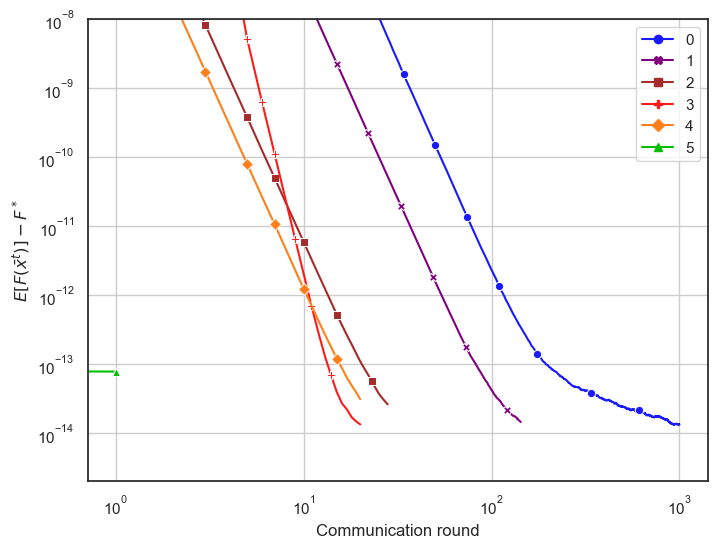

In [36]:
plt.figure(figsize=(8,6))
ax = sns.lineplot(x = 'comm', y= 'error', data = comm_df, #.loc[comm_df['method'].isin([plot_labels[i] for i in [1,2,3,4]])],
                  hue = 'method', palette = plot_colors , style = 'method',  markers = True, dashes = False, markevery=.1)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlabel(r'Communication round')
plt.ylabel(r'$E[F(\bar x^t)] - F^*$')
plt.ylim([2e-15, 1e-8])
# plt.xlim([0,1100])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
# plt.savefig('figures/communication_skewed.png', dpi=240, transparent=False, bbox_inches='tight')
plt.show()

----
# Speed-up Curve

n 1
k=1, a=1000
# of comms: 1
Simulation: 250/500
Simulation: 500/500
------
n 2
k=2, a=250
# of comms: 2
Simulation: 250/500
Simulation: 500/500
------
n 4
k=4, a=63
# of comms: 4
Simulation: 250/500
Simulation: 500/500
------
n 8
k=8, a=16
# of comms: 8
Simulation: 250/500
Simulation: 500/500
------
n 16
k=16, a=4
# of comms: 16
Simulation: 250/500
Simulation: 500/500
------
n 32
k=32, a=1
# of comms: 32
Simulation: 250/500
Simulation: 500/500
------


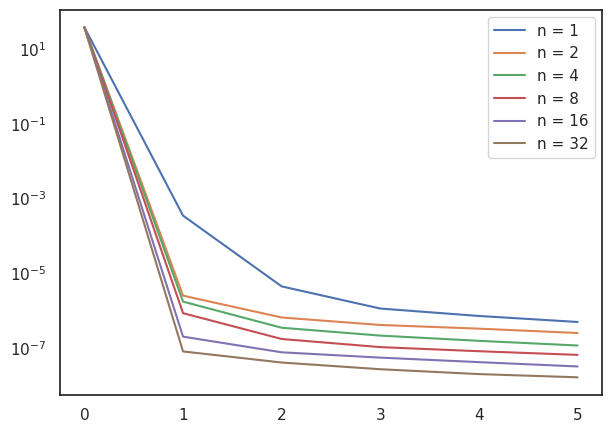

In [522]:
T=500 #4000
sigma = 1e-2
# plot_every = 100
# reps = 500
# running_dict = {}

iter_avg_dict = {}
iter_std_dict = {}
comm_dict = {}
beta = 1
# print_every = reps/2
method = 3

for n in [1, 2, 4, 8, 16, 32]:
    print('n %d'% n)
    comms = get_comms(n, method, T)
    
    k=len(comms)-1
    print('# of comms: %d' % (k))
    
    reps = 500 #int(512/n)
    print_every = reps/2
    comm_error_avg, iter_error_avg, iter_error2_avg = train_dist(comms, T, n, reps, plot_every, print_every)
    
    iter_std = np.sqrt(iter_error2_avg - iter_error_avg**2)/np.sqrt(reps)
    
    iter_avg_dict[n] = iter_error_avg
    iter_std_dict[n] = iter_std
    comm_dict[n] = comm_error_avg
#     running_dict[n] = running_error_avg
    plt.plot(iter_error_avg, '-', label = 'n = %d' % n)
    print('------')
    
plt.yscale('log')
plt.legend()
plt.show()

In [523]:
# Combining the outputs in one dataframe for Seaborn
errors = []
iters = []
methods = []
for n in [1,2,4,8,16,32]:
    errors = np.append(errors, iter_avg_dict[n])
    iters = np.append(iters, plot_every*np.arange(len(iter_avg_dict[n]))+1)
    methods += [r'$n = %d$'%n]*len(iter_avg_dict[n])


iter_dict_comb = {'iter': iters, 'error': errors, 'method': methods}
iter_df = pd.DataFrame(iter_dict_comb)
iter_df.head()

,iter,error,method
0,1.0,3.750000e+01,$n = 1$
1,101.0,3.427684e-04,$n = 1$
2,201.0,4.383998e-06,$n = 1$
3,301.0,1.120411e-06,$n = 1$
4,401.0,7.091003e-07,$n = 1$


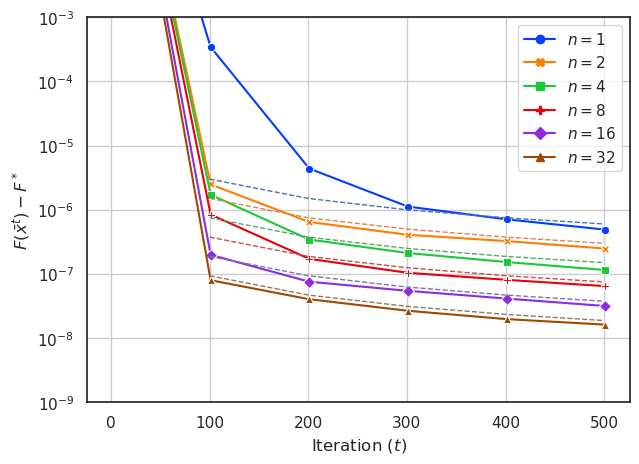

In [527]:
ax = sns.lineplot(x = 'iter', y= 'error', hue = 'method', palette = 'bright', style = 'method',  markers = True, dashes = False, data = iter_df,  markevery=.1)

plt.gca().set_prop_cycle(None)
for n in iter_avg_dict.keys():
    plt.plot(plot_every*np.arange(1,T/plot_every+1), d*(sigma**2)/(n*(plot_every*np.arange(1,T/plot_every+1))), '--', linewidth = 1)
    
plt.yscale('log')
plt.ylim([1e-9,1e-3])
plt.grid()
plt.xlabel(r'Iteration $(t)$')
plt.ylabel(r'$F(\bar x^t) - F^*$')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])

file_name = 'skewed_c{:.2f}_d{}_sigma{}_T{}_{}x_speedup.png'.format(c,d,sigma,T,reps)
plt.savefig(file_name, dpi=240, transparent=False, bbox_inches='tight')